Make J-plot from SOHO/LASCO C3 images to track the speed of a solar feature

In [2]:
import matplotlib
matplotlib.use('TkAgg')

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import UnivariateSpline
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
from scipy import stats
import sunpy.sun.constants as const

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'
savedir = '/home/mnedal/repos/dias_work'

In [3]:
detector = 'C3'
os.makedirs(f'{savedir}/jplots/lasco_{detector}/clicking', exist_ok=True)

In [4]:
def split_datetime(start=None, end=None):
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict




def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec
    
    # Define the center point of the line (e.g., the center of the Sun)
    center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_obj.coordinate_frame)
    
    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point   = SkyCoord(center.Tx + line_length * np.cos(angle_rad), 
                           center.Ty + line_length * np.sin(angle_rad),
                           frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line



def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]



def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())



def apply_runratio(maps):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs: list of EUV sunpy maps.
        Output: sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax



def round_obstime(time=None):
    """
    Round the observation time to put it in the image title.
    Input : str, time (HH:MM:SS.sss)
    Output: str, datetime (YYYY-mm-DD HH:MM:SS)
    """
    from datetime import datetime, timedelta

    original_time_str = time

    # Convert the original time string to a datetime object
    original_time = datetime.strptime(original_time_str, '%H:%M:%S.%f')

    # Round the time to the nearest second
    rounded_time = original_time + timedelta(seconds=round(original_time.microsecond / 1e6))

    # Format the rounded time as 'HH:MM:SS'
    rounded_time_str = rounded_time.strftime('%H:%M:%S')
    
    return rounded_time_str



def load_lasco(start=None, end=None, detector='C2'):
    """
    Load SOHO/LASCO C2 or C3 images as sunpy maps.
    """
    dt_dict = split_datetime(start=start, end=end)
    data = sorted(glob.glob(f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    
    start_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 and C3 jp2 images
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects



def generate_number_list_float(center, offset, count):
    """
    Generate a list of numbers around a given center number.

    Parameters:
    center (int or float): The central number of the list.
    offset (int or float): The increment by which numbers are spaced from the center.
    count (int): The number of numbers to include on each side of the center number.

    Returns:
    list: A list of numbers around the given center.

    Example usage:
        center_number = 0
        offset_value = 2
        count_around = 3
        number_list = generate_number_list(center_number, offset_value, count_around)
        print(number_list)
        [-6, -4, -2, 0, 2, 4, 6]
    """
    return [center + offset * i for i in range(-count, count + 1)]



def generate_number_list_time(center, offset, count):
    """
    Generate a list of time numbers around a given center date number.

    Parameters:
    center (int or float): The central date number of the list.
    offset (int or float): The increment by which numbers are spaced from the center, in minutes.
    count (int): The number of numbers to include on each side of the center number.

    Returns:
    list: A list of date numbers around the given center.

    Example usage:
        center_number = 19857.763069 # equivalent to 2024-05-14 18:18:49.161600+00:00
        offset_value = 2 # in minutes
        count_around = 2
        number_list = generate_number_list_time(center_number, offset_value, count_around)
        print(number_list)
    """
    # Convert center date number to datetime object
    center_date = mdates.num2date(center)

    # Generate list of date numbers
    list_dates = []
    for i in range(-count, count + 1):
        # Calculate the new date by adding the offset in minutes
        new_date = center_date + timedelta(minutes=offset * i)
        # Convert the datetime object back to a date number
        new_date_number = mdates.date2num(new_date)
        list_dates.append(new_date_number)
    
    return list_dates



# def compute_standard_error(values_list):
#     values_array = np.array(values_list)
#     mean_values = np.mean(values_array, axis=0)
#     standard_error = np.std(values_array, axis=0, ddof=1) / np.sqrt(values_array.shape[0])
#     return mean_values, standard_error


def compute_standard_error(coords_dict):
    # Extract all trials
    trials = list(coords_dict.values())
    num_points = len(trials[0])  # Number of points in each trial

    # Initialize lists to store standard errors
    mean_values = []
    standard_errors = []

    # Loop over each point position
    for point_idx in range(num_points):
        # Extract x and y values for this point across all trials
        x_values = [trials[trial_idx][point_idx][0] for trial_idx in range(len(trials))]
        y_values = [trials[trial_idx][point_idx][1] for trial_idx in range(len(trials))]

        # Convert to numpy arrays
        x_values = np.array(x_values)
        y_values = np.array(y_values)

        # Compute mean and standard error for this point
        mean_x = np.mean(x_values)
        mean_y = np.mean(y_values)
        se_x = np.std(x_values, ddof=1) / np.sqrt(len(x_values))
        se_y = np.std(y_values, ddof=1) / np.sqrt(len(y_values))

        # Store results
        mean_values.append((mean_x, mean_y))
        standard_errors.append((se_x, se_y))

    return mean_values, standard_errors

In [5]:
lasco_c3_map_objects = load_lasco(start='2024-05-14T17:45:00', end='2024-05-14T23:59:59', detector='C3')

LASCO C3 image 0 is done
LASCO C3 image 1 is done
LASCO C3 image 2 is done
LASCO C3 image 3 is done
LASCO C3 image 4 is done
LASCO C3 image 5 is done
LASCO C3 image 6 is done
LASCO C3 image 7 is done
LASCO C3 image 8 is done
LASCO C3 image 9 is done
LASCO C3 image 10 is done
LASCO C3 image 11 is done
LASCO C3 image 12 is done
LASCO C3 image 13 is done
LASCO C3 image 14 is done
LASCO C3 image 15 is done
LASCO C3 image 16 is done
LASCO C3 image 17 is done
LASCO C3 image 18 is done
LASCO C3 image 19 is done
LASCO C3 image 20 is done
LASCO C3 image 21 is done
LASCO C3 image 22 is done
LASCO C3 image 23 is done
LASCO C3 image 24 is done
LASCO C3 image 25 is done
LASCO C3 image 26 is done
LASCO C3 image 27 is done
LASCO C3 image 28 is done
LASCO C3 image 29 is done
LASCO C3 image 30 is done
LASCO C3 image 31 is done
LASCO C3 image 32 is done
LASCO C3 image 33 is done
LASCO C3 image 34 is done
LASCO C3 image 35 is done
LASCO C3 image 36 is done
LASCO C3 image 37 is done
LASCO C3 image 38 is d

In [6]:
# remove redundant images
clean_maps_c3 = remove_redundant_maps(lasco_c3_map_objects)

print(f'Before:\nLASCO C3: {len(lasco_c3_map_objects)} images\n')
print(f'After:\nLASCO C3: {len(clean_maps_c3)} images')

Before:
LASCO C3: 374 images

After:
LASCO C3: 29 images


In [7]:
# Test plot ...
fig = plt.figure(figsize=[10,5])

m = clean_maps_c3[9]
ax = fig.add_subplot(121, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame))
x_pixel, y_pixel = pixel_coords
ax.scatter(x_pixel, y_pixel, c='y', s=20)
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)

m = clean_maps_c3[9]
crop_length = 5000
top_right = SkyCoord(crop_length * u.arcsec, crop_length * u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-crop_length * u.arcsec, -crop_length * u.arcsec, frame=m.coordinate_frame)
submap = m.submap(bottom_left, top_right=top_right)
ax = fig.add_subplot(122, projection=submap)
submap.plot(axes=ax)
submap.draw_limb()
pixel_coords = submap.wcs.world_to_pixel(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=submap.coordinate_frame))
x_pixel, y_pixel = pixel_coords
ax.scatter(x_pixel, y_pixel, c='y', s=30)
ax.axvline(x=x_pixel, color='w', linestyle='--', alpha=0.5)
ax.axhline(y=y_pixel, color='w', linestyle='--', alpha=0.5)
ax.grid(False)

fig.tight_layout()
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [8]:
# make run-diff maps
m_seq_runratio_c3 = apply_runratio(clean_maps_c3)

In [9]:
print(len(clean_maps_c3))

29


In [13]:
slits = True
centered_list = generate_centered_list(160, 2, 6)

fig = plt.figure(figsize=[7,7])

m = m_seq_runratio_c3[10]
ax = fig.add_subplot(111, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
ax.set_title(m.latex_name.replace('Clear white-light 2024-05-14', ''))
# plt.colorbar(img, pad=0.02, shrink=0.8)

if slits:
    for value in centered_list:
        line = plot_line(angle_deg=value, length=31000, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 5, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')

ax.set_xlim(left=-80, right=500)
ax.set_ylim(bottom=420, top=870)
fig.tight_layout()
fig.savefig(f"{data_dir}/LASCO_{m.meta['detector']}_{m.meta['date_obs'].replace('/','-')}T{m.meta['time_obs']}.pdf", format='pdf', bbox_inches='tight')
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


## J-Maps for LASCO C3

In [10]:
# Make a dictionary to hold the lists of lists
intensity_dict = {}
distances_dict = {}
output_obj = {}
jmaps_coords_list = {}

# Initialize each key with an empty list
for value in centered_list:
    intensity_dict[f'intensity_{value}deg'] = []
    distances_dict[f'distances_{value}deg'] = []
    output_obj[f'intensity_{value}deg'] = []
    output_obj[f'distances_{value}deg'] = []
    jmaps_coords_list[f'{value}'] = []

output_obj['time'] = []
output_obj['map_obj'] = []
output_obj['instrument'] = []

for i, m in enumerate(m_seq_runratio_c3):
    print(f'Working on map {i} ..')
    
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=m)
    m.plot(axes=ax)
    
    for value in centered_list:
        line = plot_line(angle_deg=value, length=31000, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')
        
        # obtain the coordinates of the map pixels that intersect that path
        intensity_coords_slit = sunpy.map.pixelate_coord_path(m, line)
        
        # Create mask to identify valid coordinates
        valid_mask = sunpy.map.contains_coordinate(m, intensity_coords_slit)
        
        # Apply the mask to filter valid coordinates
        valid_coords = intensity_coords_slit[valid_mask]
        
        # Pass those coordinates to extract the values for those map pixels
        intensity_slit = sunpy.map.sample_at_coords(m, valid_coords)
        
        # Calculate the angular separation between the first point and every other coordinate we extracted
        angular_separation_slit = valid_coords.separation(valid_coords[0]).to(u.arcsec)
        
        # Append the values to the lists
        intensity_dict[f'intensity_{value}deg'].append(list(intensity_slit.value))
        distances_dict[f'distances_{value}deg'].append(list(angular_separation_slit.value))
    
    output_obj['time'].append(m.date.iso)
    output_obj['map_obj'].append(m)
    output_obj['instrument'].append(f"{m.meta['instrume']}_{m.meta['detector']}")
    
    plt.close()

Working on map 0 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 1 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 3 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 4 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 5 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 6 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 7 ..
INFO: Missing metadata for solar radius: assuming the standard radius 

In [11]:
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

for value in centered_list:
    intens = np.array(intensity_dict[f'intensity_{value}deg']).T
    height = np.array(distances_dict[f'distances_{value}deg'][0])
    output_obj[f'intensity_{value}deg'].append(intens)
    output_obj[f'distances_{value}deg'].append(height)

In [12]:
list(intensity_dict.keys())

['intensity_148deg',
 'intensity_150deg',
 'intensity_152deg',
 'intensity_154deg',
 'intensity_156deg',
 'intensity_158deg',
 'intensity_160deg',
 'intensity_162deg',
 'intensity_164deg',
 'intensity_166deg',
 'intensity_168deg',
 'intensity_170deg',
 'intensity_172deg']

In [13]:
list(distances_dict.keys())

['distances_148deg',
 'distances_150deg',
 'distances_152deg',
 'distances_154deg',
 'distances_156deg',
 'distances_158deg',
 'distances_160deg',
 'distances_162deg',
 'distances_164deg',
 'distances_166deg',
 'distances_168deg',
 'distances_170deg',
 'distances_172deg']

In [14]:
list(output_obj.keys())

['intensity_148deg',
 'distances_148deg',
 'intensity_150deg',
 'distances_150deg',
 'intensity_152deg',
 'distances_152deg',
 'intensity_154deg',
 'distances_154deg',
 'intensity_156deg',
 'distances_156deg',
 'intensity_158deg',
 'distances_158deg',
 'intensity_160deg',
 'distances_160deg',
 'intensity_162deg',
 'distances_162deg',
 'intensity_164deg',
 'distances_164deg',
 'intensity_166deg',
 'distances_166deg',
 'intensity_168deg',
 'distances_168deg',
 'intensity_170deg',
 'distances_170deg',
 'intensity_172deg',
 'distances_172deg',
 'time',
 'map_obj',
 'instrument']

In [15]:
centered_list

[148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172]

In [16]:
angle = 172

height = output_obj[f'distances_{angle}deg'][0].copy()
intens = output_obj[f'intensity_{angle}deg'][0].copy()

lasco_map = output_obj['map_obj'][0]

In [17]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(datenum_arr, height, intens, vmin=0.8, vmax=1.7, cmap='Greys_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f'Slit {angle} deg')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlim(right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 23:45:00"))
ax.set_ylim(bottom=3500, top=29500)
plt.show()

In [23]:
# conversion from arcsec to solar radius
dist_rsun = height/lasco_map.rsun_obs.value

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(datenum_arr, dist_rsun, intens, vmin=0.8, vmax=1.7, cmap='Greys_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(f'Slit {angle} deg')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlim(right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 23:45:00"))
ax.set_ylim(bottom=4, top=31)
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


### Clicking ...

In [125]:
# matplotlib.use('nbAgg')

In [126]:
# # initiate an empty dict to store the coords in each trial
# num_repeats = 5

# feature_coords_slit = {}
# for i in range(num_repeats):
#     feature_coords_slit[f'trial_{i}'] = []

# feature_coords_slit

In [18]:
# Number of repetitions
num_repeats = 5
current_trial = 0

# Dictionary to store coordinates for each trial
feature_coords_slit = {f'trial_{i}': [] for i in range(num_repeats)}

# List to store coordinates
# feature_coords_slit = []
jmap_points_with_error = {'x_mean': [], 'y_mean': [],
                         'x_err': [], 'y_err': []}

# Text handle to update on the plot
text_handle = None

def onclick(event):
    """
    This function is called when the mouse is clicked on the figure.
    It adds the x and y coordinates of the click to the coords list.
    """
    global current_trial, text_handle

    if event.button == 1:  # Left mouse button
        xx, yy = event.xdata, event.ydata  # Get the central x and y coordinates
        ax.plot(xx, yy, 'ro', markersize=4)
        plt.draw()

        # Store the coordinates in the current trial's list
        feature_coords_slit[f'trial_{current_trial}'].append((xx, yy))
        
        # Update the text on the plot
        if text_handle:
            text_handle.remove()  # Remove the previous text
        text_handle = ax.text(0.05, 0.95, f"Trial {current_trial + 1}: Captured ({xx:.2f}, {yy:.2f})", 
                              transform=ax.transAxes, fontsize=12, verticalalignment='top', color='pink')
        plt.draw()

    elif event.button == 3:  # Right mouse button
        # Move to the next trial
        current_trial += 1
        if current_trial >= num_repeats:
            fig.canvas.mpl_disconnect(cid)
            plt.close(fig)  # Close the figure window
        else:
            if text_handle:
                text_handle.remove()
            text_handle = ax.text(0.05, 0.95, f"Moving to trial {current_trial + 1}", 
                                  transform=ax.transAxes, fontsize=12, verticalalignment='top', color='cyan')
            plt.draw()

In [19]:
# plot the j-map
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
plt.ion()
ax.pcolormesh(datenum_arr, height, intens, vmin=0.8, vmax=1.7, cmap='Greys_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument'][0]} Intensity Along Slit {angle} deg")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlim(right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 23:45:00"))
ax.set_ylim(bottom=3500, top=29500)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show(block=False)
plt.pause(0.001)

In [22]:
mean_values, standard_errors = compute_standard_error(feature_coords_slit)
x_mean, y_mean = zip(*mean_values)
x_err, y_err = zip(*standard_errors)

df = pd.DataFrame({'time': x_mean, 'distance': y_mean,
                   'x_err': x_err, 'y_err': y_err})
display(df)

# import pickle

# event_date = output_obj['time'][0].split(' ')[0].replace('-','')
# output_filename = f"jmap_{output_obj['instrument'][0]}_{event_date}_slit_{angle}"

# with open(f'{savedir}/jplots/lasco_{detector}/clicking/coords_{output_filename}.pkl', 'wb') as file:
#     pickle.dump(feature_coords_slit, file)

# print(f"J-plot data saved at: {savedir}/jplots/lasco_{detector}/clicking/jmap_{output_obj['instrument'][0]}_{output_obj['time'][0].split(' ')[0].replace('-','')}_slit_{angle}.pkl")

ValueError: not enough values to unpack (expected 2, got 0)

In [130]:
df.to_pickle(f"{data_dir}/jplots/lasco_{detector}/clicking/jmap_{output_obj['instrument'][0]}_{output_obj['time'][0].split(' ')[0].replace('-','')}_slit_{angle}.pkl")
print(f"J-plot data saved at: {data_dir}/jplots/lasco_{detector}/clicking/jmap_{output_obj['instrument'][0]}_{output_obj['time'][0].split(' ')[0].replace('-','')}_slit_{angle}.pkl")

J-plot data saved at: /home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_172.pkl


### Fitting the points

In [131]:
# Extract time and distance arrays from the selected coordinates
times_f, distances = zip(*mean_values)

# Convert times to matplotlib date numbers
times_num = np.array(times_f)

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/lasco_map.rsun_obs
print(conversion_factor)

695700.0 km
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
733.1029920180301 km / arcsec


In [132]:
# convert distance from arcsec to km
df['distance_km'] = df['distance'] * conversion_factor

# calculate the distance difference in km
df['distance_diff_km'] = df['distance_km'].diff()

# convert time to datetime format
df['datetime'] = [mdates.num2date(t) for t in df['time']]

# calculate the time difference in seconds
df['time_diff_s'] = df['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']

# # drop the first row which will have NaN values for the differences
# df.dropna(inplace=True)

In [133]:
# Calculate spline fit
spline = UnivariateSpline(times_num, distances, k=1, s=None)  # s=0 for interpolation through all points

# Generate the spline line
spline_times = np.linspace(min(times_num), max(times_num), 1000)
spline_distances = spline(spline_times)

# Calculate the derivative of spline_distances with respect to spline_times
spline_velocity = spline.derivative()(spline_times)

# Convert velocity (in arcsec/day) to speed in km/s
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s

# Calculate the polynomial fit
polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
polyfit_line = np.polyval(polyfit_coeff, spline_times)

# Calculate the derivative of the polynomial fit (velocity)
polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s

In [134]:
display(df)

,time,distance,x_err,y_err,distance_km,distance_diff_km,datetime,time_diff_s,speed_km_s
0,19857.753613,4494.747217,0.001001,67.187031,3.295113e+06,NaN,2024-05-14 18:05:12.181816+00:00,NaN,NaN
1,19857.761671,5748.921614,0.000792,93.286840,4.214552e+06,9.194390e+05,2024-05-14 18:16:48.410179+00:00,696.228363,1320.599751
2,19857.770369,7215.340909,0.000794,138.635549,5.289588e+06,1.075036e+06,2024-05-14 18:29:19.894762+00:00,751.484583,1430.550136
3,19857.778555,8681.760204,0.000904,130.330485,6.364624e+06,1.075036e+06,2024-05-14 18:41:07.174370+00:00,707.279608,1519.959519
4,19857.787381,9578.977273,0.000747,87.095032,7.022377e+06,6.577525e+05,2024-05-14 18:53:49.710197+00:00,762.535827,862.585723
5,19857.795887,10968.216605,0.000703,114.760597,8.040832e+06,1.018456e+06,2024-05-14 19:06:04.617914+00:00,734.907717,1385.827754
6,19857.803817,12164.506030,0.000736,130.687067,8.917836e+06,8.770034e+05,2024-05-14 19:17:29.795034+00:00,685.177120,1279.965911
7,19857.812387,13254.673006,0.000848,127.076229,9.717040e+06,7.992047e+05,2024-05-14 19:29:50.228374+00:00,740.433340,1079.374238
8,19857.829335,15473.596939,0.000907,171.497629,1.134374e+07,1.626700e+06,2024-05-14 19:54:14.518186+00:00,1464.289812,1110.913810
9,19857.837457,17142.613636,0.000689,170.954053,1.256730e+07,1.223561e+06,2024-05-14 20:05:56.272172+00:00,701.753986,1743.575611


<IPython.core.display.Javascript object>


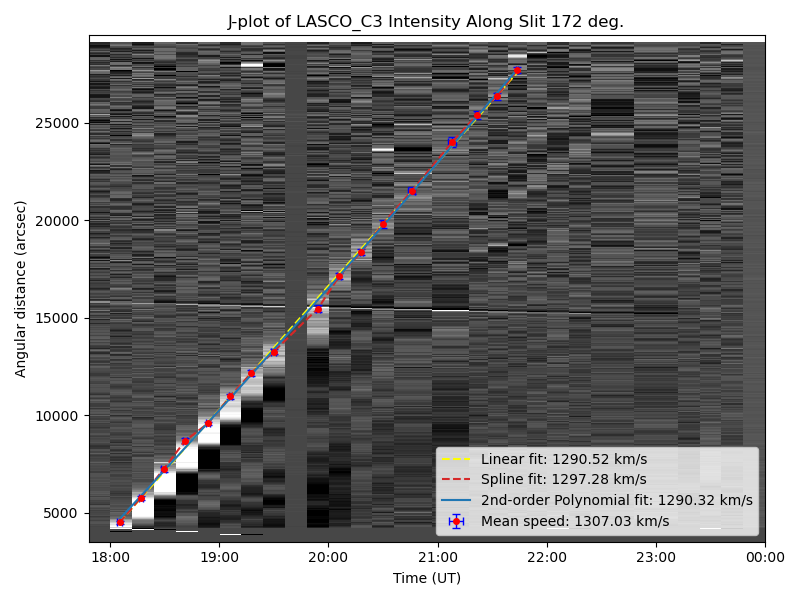

Figure: jmap_lasco_C3_20240514_slit_172.png has been exported.

J-plot data saved at: /home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_172.csv


In [135]:
event_date = output_obj['time'][0].split(' ')[0].replace('-','')

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(datenum_arr, height, intens, vmin=0.8, vmax=1.7, cmap='Greys_r')

# Plot the fitted line
fit_line = slope*times_num + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_fit = slope * conversion_factor.value/86400  # km/s
speed = np.nanmean(df['speed_km_s'])

# Plot the selected points
ax.errorbar(x_mean, y_mean, xerr=x_err, yerr=y_err,
            fmt='ro', ecolor='blue', barsabove=False,
            markersize=4, elinewidth=1, capsize=3, label=f'Mean speed: {speed:.2f} km/s')

ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Linear fit: {speed_fit:.2f} km/s')

# Plot the spline fit line
ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
        label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')

# Plot the polynomial fit line
ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
           label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument'][0]} Intensity Along Slit {angle} deg.")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(loc='lower right')
ax.set_ylim(bottom=3500, top=29500)
fig.tight_layout()

png_filename = f'jmap_lasco_{detector}_{event_date}_slit_{angle}.png'
fig.savefig(f'{data_dir}/jplots/lasco_{detector}/clicking/{png_filename}',
            format='png', bbox_inches='tight')
print(f'Figure: {png_filename} has been exported.\n')

plt.show()

output_filename = f"jmap_{output_obj['instrument'][0]}_{event_date}_slit_{angle}"
df.to_csv(f'{data_dir}/jplots/lasco_{detector}/clicking/{output_filename}.csv')
print(f'J-plot data saved at: {data_dir}/jplots/lasco_{detector}/clicking/{output_filename}.csv')

### Doing all the slits one by one because the for-loop didn't work ...

In [1]:
print(centered_list)

NameError: name 'centered_list' is not defined

In [ ]:
angle = 166

height = output_obj[f'distances_{angle}deg'][0].copy()
intens = output_obj[f'intensity_{angle}deg'][0].copy()

print(f'Working on slit: {angle} deg.')

# Number of repetitions
num_repeats = 5
current_trial = 0

# Dictionary to store coordinates for each trial
feature_coords_slit = {f'trial_{i}': [] for i in range(num_repeats)}

# Text handle to update on the plot
text_handle = None

# plot the J-map
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
plt.ion()
ax.pcolormesh(datenum_arr, height, intens, vmin=0.7, vmax=1.8, cmap='Greys_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument'][0]} Intensity Along Slit {angle} deg.")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlim(right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 23:45:00"))
ax.set_ylim(bottom=3200, top=29500)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [ ]:
# calc the standard error
mean_values, standard_errors = compute_standard_error(feature_coords_slit)

x_mean, y_mean = zip(*mean_values)
x_err, y_err = zip(*standard_errors)

event_date = output_obj['time'][0].split(' ')[0].replace('-','')
output_filename = f"jmap_{output_obj['instrument'][0]}_{event_date}_slit_{angle}"

df = pd.DataFrame({'time': x_mean, 'distance': y_mean,
                   'x_err': x_err, 'y_err': y_err})
df.to_pickle(f'{savedir}/jplots/lasco_{detector}/clicking/coords_{output_filename}.pkl')

# Extract time and distance arrays from the selected coordinates
times_num, distances = df['time'].values, df['distance'].values

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)

# conversion factor from arcsec to km
conversion_factor = sol_rad/output_obj['map_obj'][0].rsun_obs

# store the curve points with error bars
df['x_mean'] = x_mean
df['y_mean'] = y_mean
df['x_err'] = x_err
df['y_err'] = y_err

# convert distance from arcsec to km
df['distance_km'] = distances * conversion_factor.value

# calculate the distance difference in km
df['distance_diff_km'] = df['distance_km'].diff()

# convert time to datetime format
df['datetime'] = [mdates.num2date(t) for t in times_num]

# calculate the time difference in seconds
df['time_diff_s'] = df['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']

df.to_csv(f'{savedir}/jplots/lasco_{detector}/clicking/{output_filename}.csv')
print(f'J-plot data saved at: {savedir}/jplots/lasco_{detector}/clicking/{output_filename}.csv')

# # drop the first row which will have NaN values for the differences
# df.dropna(inplace=True)

# Calculate spline fit
spline = UnivariateSpline(times_num, distances, k=1, s=None) # s=0 for interpolation through all points

# Generate the spline line
spline_times = np.linspace(min(times_num), max(times_num), 1000)
spline_distances = spline(spline_times)

# Calculate the derivative of spline_distances with respect to spline_times
spline_velocity = spline.derivative()(spline_times)

# Convert velocity (in arcsec/day) to speed in km/s
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s

# Calculate the polynomial fit
polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
polyfit_line = np.polyval(polyfit_coeff, spline_times)

# Calculate the derivative of the polynomial fit (velocity)
polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s

# show the final J-map with the fitting lines and speed estimations
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(datenum_arr, height, intens, vmin=0.7, vmax=1.8, cmap='Greys_r')

# Plot the fitted line
fit_line = slope*times_num + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
speed_fit = slope * conversion_factor.value/86400  # km/s
speed = df['speed_km_s'].mean()

# Plot the selected points with error bars
ax.errorbar(x_mean, y_mean, xerr=x_err, yerr=y_err,
            fmt='ro', ecolor='blue', barsabove=False,
            markersize=4, elinewidth=1, capsize=3, label=f'Mean speed: {speed:.2f} km/s')

ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Linear fit: {speed_fit:.2f} km/s')

# Plot the spline fit line
ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
        label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')

# Plot the polynomial fit line
ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
           label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument'][0]} Intensity Along Slit {angle} deg.")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(loc='lower right')
ax.set_ylim(bottom=3200, top=29500)
fig.tight_layout()
png_filename = f'jmap_lasco_{detector}_{event_date}_slit_{angle}.png'
fig.savefig(f'{savedir}/jplots/lasco_{detector}/clicking/{png_filename}',
            format='png', bbox_inches='tight')
print(f'Figure: {png_filename} has been exported.\n')
plt.show()